## Виртуальный датчик

In [81]:
import pandas as pd 

df_data = pd.read_csv('data_lec.csv',  parse_dates=['timestamp'])
df_target = pd.read_csv('target_lec.csv',  parse_dates=['timestamp'])

# Приведение данных к временной шкале с фиксированным шагом
# Устанавливаем индекс для временных меток
df_data.set_index('timestamp', inplace=True)
df_target.set_index('timestamp', inplace=True)

# Интерполяция target на частоту data (1 минута)
df_target_interpolated = df_target.resample('1T').interpolate(method='linear')

start_date = df_target_interpolated.index.min()
end_date = df_target_interpolated.index.max()

# Выделим нужный участок из df_data
df_data_selected = df_data.loc[start_date:end_date]

# Объединим df_data_selected с df_target_interpolated, добавив target в отдельную колонку
df_combined = df_data_selected.join(df_target_interpolated, rsuffix='_target')

C:\Users\minak\AppData\Local\Temp\ipykernel_20448\2374762836.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_target_interpolated = df_target.resample('1T').interpolate(method='linear')


In [95]:
from sklearn.preprocessing import MinMaxScaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Применяем MinMaxScaler к df_combined, чтобы нормализовать все числовые столбцы
df_combined = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)


for i in range(1, 16):
    df_combined[f'target_lag_{i}'] = df_combined['target'].shift(i)
       
df_combined = df_combined.fillna(method='bfill').dropna()
# Вычисляем длины каждого набора
total_length = len(df_combined)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.9)

# Разделение данных
train_data = df_combined.iloc[:train_end]
val_data = df_combined.iloc[train_end:val_end]
test_data = df_combined.iloc[val_end:]

# Проверим размеры каждого набора для подтверждения
train_data_size = len(train_data)
val_data_size = len(val_data)
test_data_size = len(test_data)

C:\Users\minak\AppData\Local\Temp\ipykernel_20448\570234787.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined = df_combined.fillna(method='bfill').dropna()


In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Подготовка признаков и целевой переменной
X_train = train_data.drop(columns=['target_target'])
y_train = train_data['target_target']

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на тренировочном наборе
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

rmse_train

0.04232977373012458

<Axes: xlabel='timestamp'>

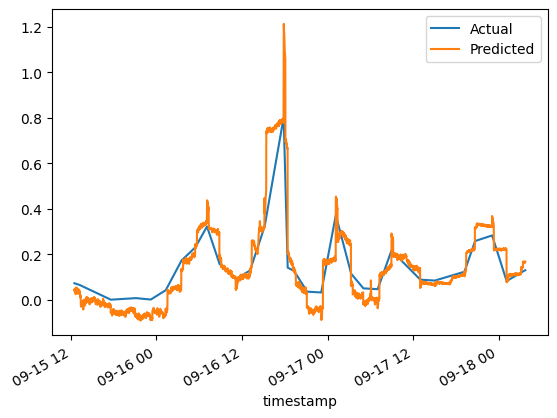

In [97]:
# Подготовка признаков и целевой переменной для валидации
X_val = val_data.drop(columns=['target_target'])
y_val = val_data['target_target']

# Прогнозирование на валидационном наборе
y_pred_val = model.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

val_results.plot()

In [98]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse_val)

Validation RMSE: 0.07729090125466566


### Попробуем XGBRegressor

In [99]:
from xgboost import XGBRegressor


# Создание и настройка модели XGBoost
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Обучение модели XGBoost
model_xgb.fit(X_train, y_train)

# Прогнозирование на валидационном наборе
y_pred_val_xgb = model_xgb.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results_xgb = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val_xgb
})

<Axes: xlabel='timestamp'>

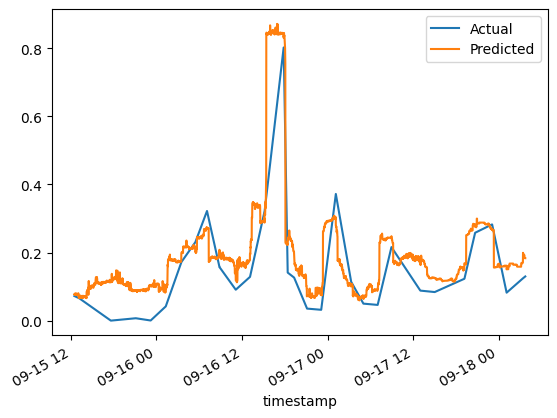

In [100]:
val_results_xgb.plot()

In [101]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
print("Validation RMSE:", rmse_val)

Validation RMSE: 0.08895905992748489


### LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13437
[LightGBM] [Info] Number of data points in the train set: 13382, number of used features: 63
[LightGBM] [Info] Start training from score 0,181734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

<Axes: xlabel='timestamp'>

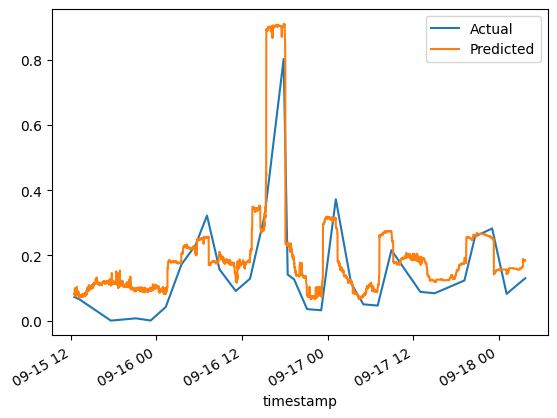

In [102]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Очистка названий признаков от специальных символов для X_train и X_val
import re
X_train.columns = [re.sub(r'\W+', '_', col) for col in X_train.columns]
X_val.columns = [re.sub(r'\W+', '_', col) for col in X_val.columns]

# Инициализация и обучение модели LGBMRegressor
model = LGBMRegressor(objective='regression', learning_rate=0.1, max_depth=5, num_leaves=31, n_estimators=100)
model.fit(X_train, y_train)

# Прогнозирование на валидационном наборе
y_pred_val_lgbm = model.predict(X_val)

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_lgbm))
print("Validation RMSE:", rmse_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results_lgbm = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val_lgbm
})

# Отображение первых нескольких строк
val_results_lgbm.plot()

In [104]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_lgbm))
print("Validation RMSE:", rmse_val)

Validation RMSE: 0.09831622440415508


### LSTM

Epoch [5/20], Loss: 0.0166
Epoch [10/20], Loss: 0.0125
Epoch [15/20], Loss: 0.0096
Epoch [20/20], Loss: 0.0063
Test RMSE: 0.3574607571386601


<Axes: >

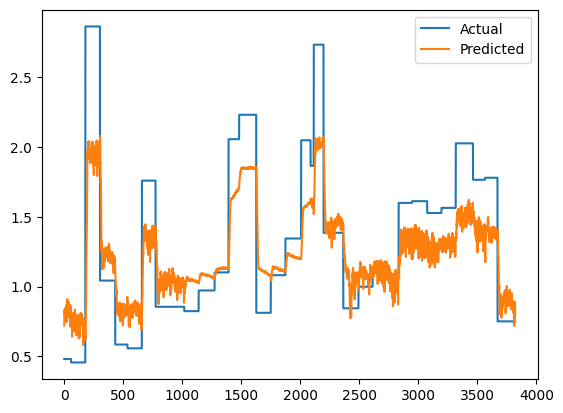

In [106]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Параметры
timesteps = 15  # Используем последние 15 минут для прогнозирования текущего значения target
batch_size = 32
epochs = 20
learning_rate = 0.001

# Создание последовательностей для LSTM
X = []
y = []

for i in range(timesteps, len(df_combined)):
    X.append(df_combined.iloc[i - timesteps:i].values)
    y.append(df_combined.iloc[i]["target"])

X, y = np.array(X), np.array(y)

# Разделение данных на тренировочный и тестовый наборы
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразование данных в тензоры PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Определение модели
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Умножаем на 2, так как двунаправленный LSTM

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последнее скрытое состояние
        return out

# Параметры модели
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1

# Инициализация модели, функции потерь и оптимизатора
model = BiLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Оценка модели на тестовом наборе
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()

# Обратное преобразование предсказаний
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), df_combined.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), df_combined.shape[1] - 1)), y_pred.cpu().numpy().reshape(-1, 1)), axis=1))[:, -1]

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print("Test RMSE:", rmse)

# Отображение реальных и предсказанных значений
results = pd.DataFrame({
    'Actual': y_test_rescaled,
    'Predicted': y_pred_rescaled
})

results.plot()

## Прогноз на 15 минут в перед

In [47]:
import pandas as pd 

df_data = pd.read_csv('data_lec.csv',  parse_dates=['timestamp'])
df_target = pd.read_csv('target_lec.csv',  parse_dates=['timestamp'])



In [48]:
# Приведение данных к временной шкале с фиксированным шагом
# Устанавливаем индекс для временных меток
df_data.set_index('timestamp', inplace=True)
df_target.set_index('timestamp', inplace=True)

# Интерполяция target на частоту data (1 минута)
df_target_interpolated = df_target.resample('1T').interpolate(method='linear')

C:\Users\minak\AppData\Local\Temp\ipykernel_20448\2389438463.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_target_interpolated = df_target.resample('1T').interpolate(method='linear')


In [49]:
start_date = df_target_interpolated.index.min()
end_date = df_target_interpolated.index.max()

# Выделим нужный участок из df_data
df_data_selected = df_data.loc[start_date:end_date]

# Объединим df_data_selected с df_target_interpolated, добавив target в отдельную колонку
df_combined = df_data_selected.join(df_target_interpolated, rsuffix='_target')

In [50]:
df_combined

,Unnamed: 0,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,temp3,...,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1,target_target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-06 07:17:00+00:00,3017,1195.454350,831.816895,847.329819,8.844165,80.359341,0.853588,0.000000,111.250000,31.433107,...,99.441243,53.25,59.571020,852.998840,NaN,NaN,4.497253,-0.283300,-1.029347,0.994800
2023-09-06 07:18:00+00:00,3018,1039.896730,833.734787,852.541763,9.774559,80.295139,0.852684,0.000000,73.500000,31.528051,...,99.433971,52.25,57.666964,855.704742,NaN,NaN,5.705383,-0.243801,-0.541925,1.005894
2023-09-06 07:19:00+00:00,3019,1051.795410,835.776062,853.039108,10.449957,79.938873,0.850875,0.000000,87.500000,31.717939,...,99.426700,53.50,56.417607,859.920242,NaN,NaN,7.153229,-0.196984,-0.067268,1.016988
2023-09-06 07:20:00+00:00,3020,1058.190430,837.580017,858.191376,9.647234,80.025679,3.050854,0.000000,125.000000,31.622995,...,99.419428,54.00,56.993423,861.524811,NaN,NaN,8.314209,-0.167878,0.386957,1.028082
2023-09-06 07:21:00+00:00,3021,1300.447000,836.155853,869.958008,7.783049,79.962383,3.268772,0.000000,129.750000,31.480579,...,99.412157,54.50,58.700148,859.587967,NaN,NaN,9.306335,-0.105204,0.856819,1.039177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19 11:18:00+00:00,22131,204.149124,800.143768,968.746384,19.999639,74.927662,69.601780,54.992676,120.750000,37.604443,...,98.953394,55.50,58.779761,871.930618,NaN,1.77973,28.461823,0.677364,1.767924,0.771429
2023-09-19 11:19:00+00:00,22132,1804.519043,801.757812,970.059280,14.463976,74.656395,69.398327,54.992676,98.750000,37.462021,...,98.954165,53.50,59.566406,870.221649,NaN,1.77973,17.812073,0.743447,1.962264,0.764522
2023-09-19 11:20:00+00:00,22133,1995.192017,800.884318,971.000875,7.474923,74.482783,69.596354,54.992676,105.333333,37.588618,...,98.954937,54.00,59.837076,866.749837,NaN,1.77973,19.248322,0.666606,2.029908,0.757616


In [51]:
df_combined['target_15min_future'] = df_combined['target_target'].shift(-15)

In [52]:
df_combined = df_combined.fillna(method='bfill').dropna()

# Вычисляем длины каждого набора
total_length = len(df_combined)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.9)

# Разделение данных
train_data = df_combined.iloc[:train_end]
val_data = df_combined.iloc[train_end:val_end]
test_data = df_combined.iloc[val_end:]

# Проверим размеры каждого набора для подтверждения
train_data_size = len(train_data)
val_data_size = len(val_data)
test_data_size = len(test_data)

C:\Users\minak\AppData\Local\Temp\ipykernel_20448\1043327439.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined = df_combined.fillna(method='bfill').dropna()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Подготовка признаков и целевой переменной
X_train = train_data.drop(columns=['target_15min_future'])
y_train = train_data['target_15min_future']

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на тренировочном наборе
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

rmse_train

0.08397902577754911

In [54]:
# Подготовка признаков и целевой переменной для валидации
X_val = val_data.drop(columns=['target_15min_future'])
y_val = val_data['target_15min_future']

# Прогнозирование на валидационном наборе
y_pred_val = model.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

<Axes: xlabel='timestamp'>

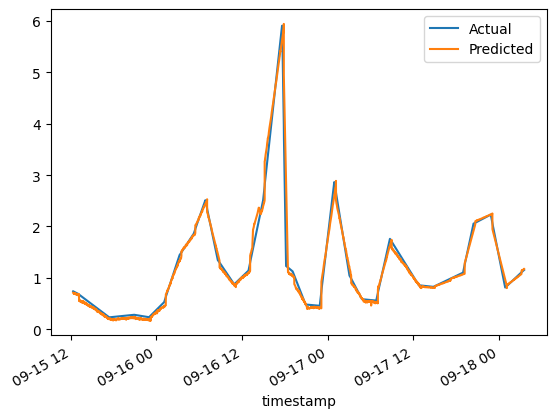

In [55]:
val_results.plot()